In [1]:
# Generales
import pandas as pd
import numpy as np
from numpy import expand_dims
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pydot as pyd
import time
import joblib

# image preprocessing
import os
import sys
import shutil
import glob
import matplotlib.image as mpimg
from PIL import Image

#sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#keras
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, BatchNormalization

# keras utils
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils.vis_utils import plot_model

#keras VGG16
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

# tensorflow
import tensorflow as tf
from tensorflow.random import set_seed

#cv2
import cv2
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%env name=samples1_512_equiv
!echo $name

env: name=samples1_512_equiv
samples1_512_equiv


In [4]:
# copy samples file to directory
!cp ./drive/Shareddrives/Memoria/samples/$name.zip ./$name.zip

!unzip -o -q $name.zip -d ./samples

In [5]:
set_seed(42)
np.random.seed(42)

In [6]:
# Constants

# dirs
inp_img_dir = "./samples/"
out_dir = ""

# init
start_num = 1

height, width = 32, 32

# placeholder
r = "rule_"

# Classes
class1 = [0, 255,
        8, 64, 239, 253,
        32, 251,
        40, 96, 235, 249,
        128, 254,
        136, 192, 238, 252,
        160, 250,
        168, 224, 234, 248]

class2 = [1, 127,
        2, 16, 191, 247,
        3, 17, 63, 119,
        4, 223,
        5, 95,
        6, 20, 159, 215,
        7, 21, 31, 87,
        9, 65, 111, 125,
        10, 80, 175, 245,
        11, 47, 81, 117,
        12, 68, 207, 221,
        13, 69, 79, 93,
        14, 84, 143, 213,
        15, 85,
        19, 55,
        23,
        24, 66, 189, 231,
        25, 61, 67, 103,
        26, 82, 167, 181,
        27, 39, 53, 83,
        28, 70, 157, 199,
        29, 71,
        33, 123,
        34, 48, 187, 243,
        35, 49, 59, 115,
        36, 219,
        37, 91,
        38, 52, 155, 211,
        42, 112, 171, 241,
        43, 113,
        44, 100, 203, 217,
        46, 116, 139, 209,
        50, 179,
        51,
        56, 98, 185, 227,
        57, 99,
        58, 114, 163, 177,
        62, 118, 131, 145,
        72, 237,
        73, 109,
        74, 88, 173, 229,
        76, 205,
        77,
        78, 92, 141, 197,
        94, 133,
        104, 233,
        108, 201,
        130, 144, 190, 246,
        132, 222,
        134, 148, 158, 214,
        138, 174, 208, 224,
        140, 196, 206, 220,
        142, 212,
        152, 188, 194, 230,
        154, 166, 180, 210,
        156, 198,
        162, 176, 186, 242,
        164, 218,
        170, 240,
        172, 202, 216, 228,
        178,
        184, 226,
        200, 236,
        204,
        232]
class3 = [18, 183,
        22, 151,
        30, 86, 135, 149,
        45, 75, 89, 101,
        60, 102, 153, 195,
        90, 165,
        105,
        122, 161,
        126, 129,
        146, 182,
        150]
class4 = [41, 97, 107, 121,
        54, 147,
        106, 120, 169, 225,
        110, 124, 137, 193]

## Dataset Generation

## Data Prep

In [7]:
def getPics(classRules, samplesDir):
    classImgs = []

    for r in classRules:
        imgsDir = samplesDir + f'rule_{str(r)}/'
        classImgs += [imgsDir + f for f in os.listdir(imgsDir)]
    return classImgs


c1_img_list = getPics(class1, inp_img_dir)
c2_img_list = getPics(class2, inp_img_dir)
c3_img_list = getPics(class3, inp_img_dir)
c4_img_list = getPics(class4, inp_img_dir)

In [8]:
len(c1_img_list), len(c2_img_list), len(c3_img_list), len(c4_img_list)

(49388, 51199, 46576, 46573)

In [9]:
files_target = [np.full(len(c1_img_list), '1', dtype=str), 
         np.full(len(c2_img_list), '2', dtype=str), 
         np.full(len(c3_img_list), '3', dtype=str), 
         np.full(len(c4_img_list), '4', dtype=str), 
         ]
[x.shape[0] for x in files_target]

[49388, 51199, 46576, 46573]

In [10]:
# Data selection

c1_x = c1_img_list.copy()
c2_x = c2_img_list.copy()
c3_x = c3_img_list.copy()
c4_x = c4_img_list.copy()

c1_y = files_target[0].copy()
c2_y = files_target[1].copy()
c3_y = files_target[2].copy()
c4_y = files_target[3].copy()

In [11]:
c_x = np.array(c1_x+c2_x+c3_x+c4_x)
c_y = np.concatenate((c1_y,c2_y,c3_y,c4_y))

In [12]:
dataset = pd.DataFrame({'img':c_x, 'class':c_y})
dataset = dataset.sample(frac=1)[:100000]
dataset

,img,class
6525,./samples/rule_64/64_000_0250_785.png,1
109900,./samples/rule_86/86_000_0013_1733.png,3
20886,./samples/rule_235/235_000_0073_3204.png,1
186640,./samples/rule_124/124_000_0009_8104.png,4
3241,./samples/rule_255/255_000_0094_9836.png,1
...,...,...
26271,./samples/rule_128/128_000_0024_2536.png,1
177041,./samples/rule_169/169_000_0148_5819.png,4
30010,./samples/rule_136/136_000_0254_5386.png,1
102762,./samples/rule_183/183_000_0039_1102.png,3


In [13]:
dataset['class'].value_counts()

2    26394
1    25445
4    24296
3    23865
Name: class, dtype: int64

## Images

In [14]:
# load test image

img = './samples/rule_110/110_000_0000_2070.png'
test_img = load_img(img, color_mode='rgb', target_size=(32, 32))
test_img = img_to_array(test_img) / 255

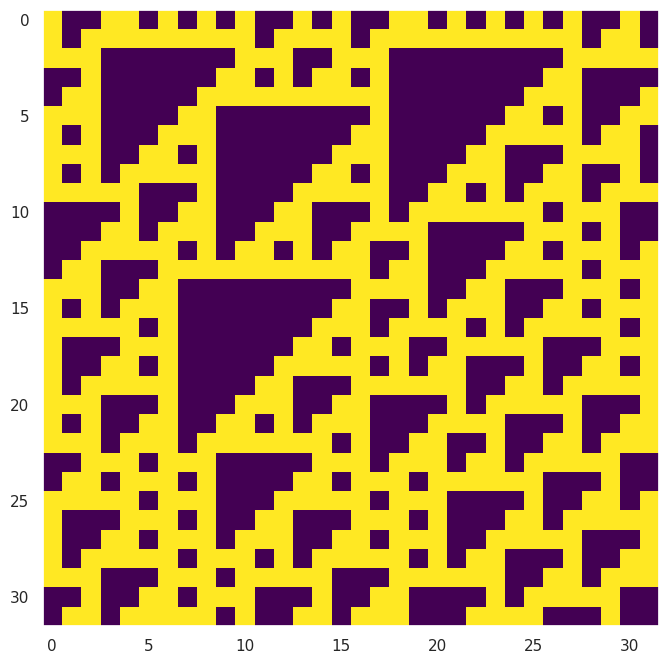

<Figure size 640x480 with 0 Axes>

In [15]:
# Image Preview
plt.figure(figsize=(16,8))

plt.imshow(array_to_img(test_img))

plt.grid(False)

plt.figure()
plt.show()

## Feature Maps Preview

In [16]:
# load the model
# input
input_shape = (height, width, 3)

model =  keras.models.load_model('./drive/Shareddrives/Memoria/code/best_models/VGG_equiv_V2_best.h5')

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [18]:
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 32, 32, 64)
2 block1_conv2 (None, 32, 32, 64)
4 block2_conv1 (None, 16, 16, 128)
5 block2_conv2 (None, 16, 16, 128)
7 block3_conv1 (None, 8, 8, 256)
8 block3_conv2 (None, 8, 8, 256)
9 block3_conv3 (None, 8, 8, 256)
11 block4_conv1 (None, 4, 4, 512)
12 block4_conv2 (None, 4, 4, 512)
13 block4_conv3 (None, 4, 4, 512)
15 block5_conv1 (None, 2, 2, 512)
16 block5_conv2 (None, 2, 2, 512)
17 block5_conv3 (None, 2, 2, 512)


1/1 [==============================] - 0s 363ms/step


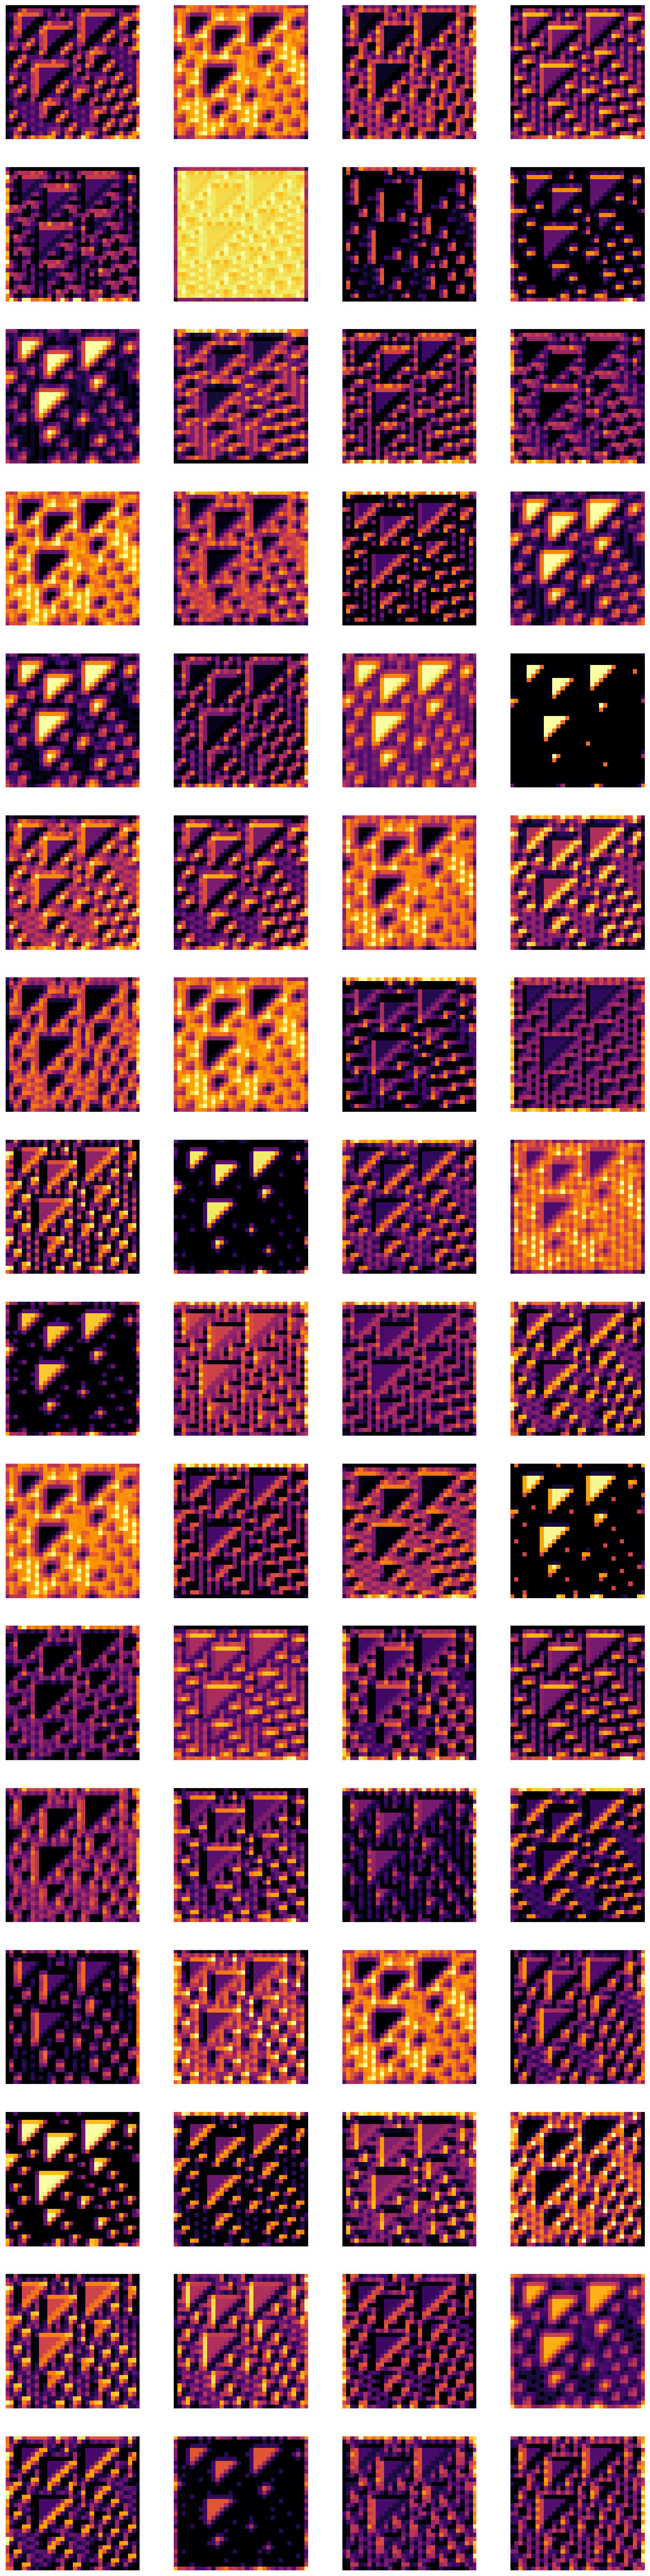

In [19]:
model_1 = Model(inputs=model.inputs, outputs=model.layers[1].output)

img = expand_dims(test_img, axis=0)

# get feature map for first hidden layer
feature_maps = model_1.predict(img)

plt.figure(figsize=(16,64))

square = 8
ix = 1
for _ in range(8):
	for _ in range(8):
		# specify subplot and turn of axis
		ax = plt.subplot(16, 4, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='inferno')
		ix += 1
# show the figure
plt.show()

1/1 [==============================] - 0s 246ms/step


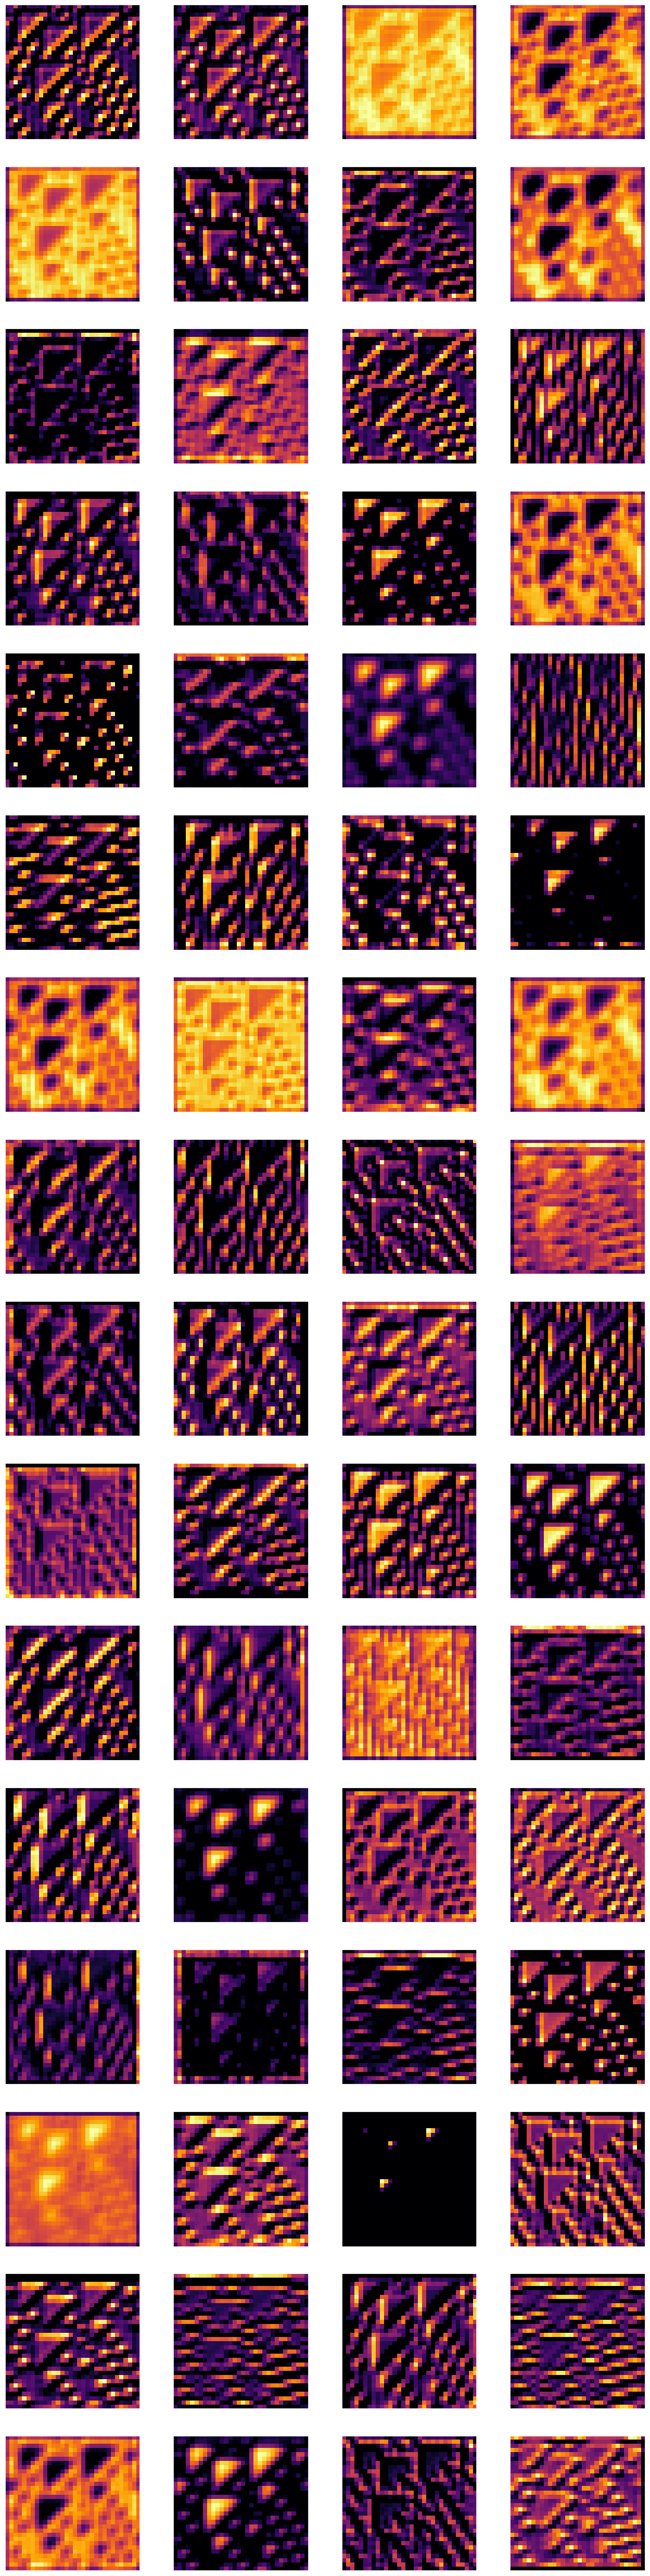

In [20]:
model_2 = Model(inputs=model_1.layers[0].output, outputs=model.layers[2].output)

img = expand_dims(test_img, axis=0)
# get feature map for first hidden layer
feature_maps = model_2.predict(img)

plt.figure(figsize=(16,64))

square = 8
ix = 1
for _ in range(8):
	for _ in range(8):
		# specify subplot and turn of axis
		ax = plt.subplot(16, 4, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='inferno')
		ix += 1
# show the figure
plt.show()

1/1 [==============================] - 0s 84ms/step


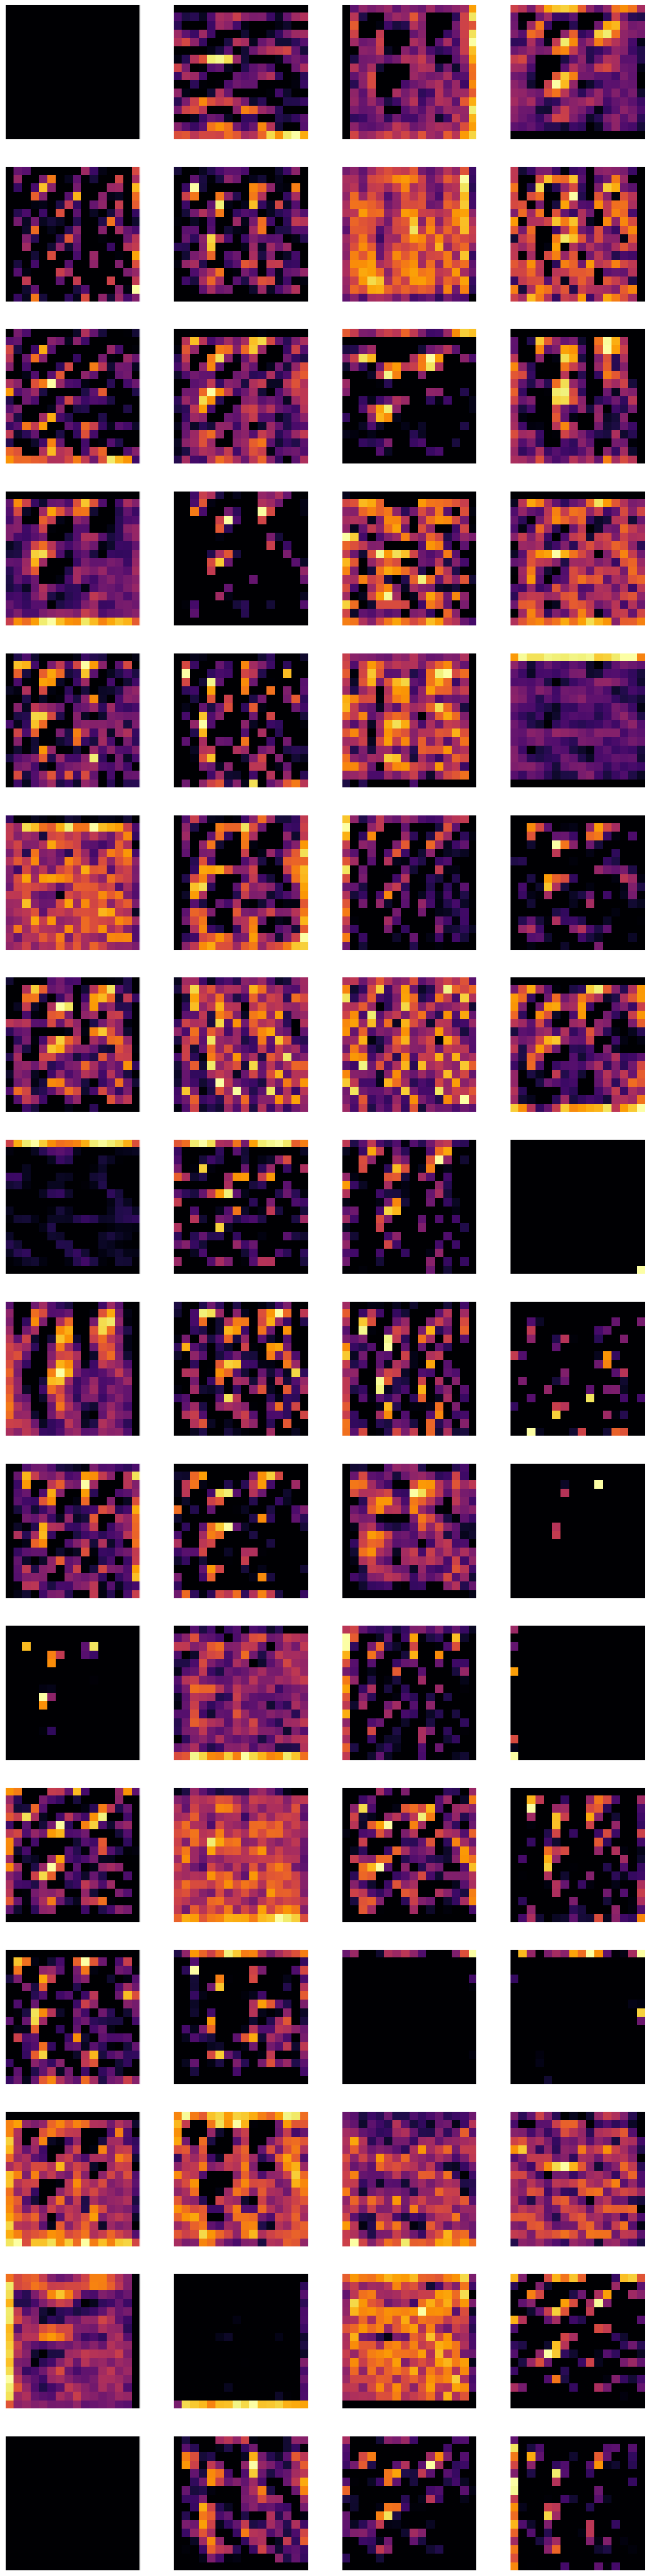

In [21]:
model_3 = Model(inputs=model_2.layers[0].output, outputs=model.layers[4].output)
 
img = expand_dims(test_img, axis=0)
# get feature map for first hidden layer
feature_maps = model_3.predict(img)

plt.figure(figsize=(16,64))

square = 8
ix = 1
for _ in range(8):
	for _ in range(8):
		# specify subplot and turn of axis
		ax = plt.subplot(16, 4, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='inferno')
		ix += 1
# show the figure
plt.show()